In [1]:
#load rpy2 magic
%load_ext rpy2.ipython

# to switch off warning messages
import warnings
warnings.filterwarnings("ignore")

# make default cell width 85% of available screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

# show multiple tables in python shells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# load R libraries & functions
%R options(warn=-1)
%R library(RColorBrewer)
%R library(ggplot2)
%R library(gplots)
%R library(gridExtra)
%R library(ggrepel)
    
# load python modules
import glob
import re
import sys
import os
import rpy2.robjects as robjects
import CGAT.Database as DB
import sqlite3
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

db = "./csvdb"

# **MEME-ChIP Report**
***
## **FIMO**
-  Searches sequences for individual matches to motifs
    -  Input motifs are those discovered by MEME & DREME
- Results from **FIMO, MEME, & DREME** are aggregated here
    - All results have corrected p-values < 0.05
    - Only MEME & DREME motifs also found by FIMO are included in this report
- No. of FIMO matches to motifs are counted, q-values and scores for each motif are averaged

In [2]:
%%R

# R functions
theme_notebook <- function(base_size=18, base_family="helvetica") {
                  (theme_set(theme_minimal(base_size=18))
                  + theme(plot.title = element_text(face="bold", size=20, hjust=0.5),
                             text = element_text(),
                             axis.title = element_text(face="bold",size = rel(1)),
                             axis.title.y = element_text(angle=90,vjust=2, size=20),
                             axis.title.x = element_text(vjust=-0.2, size=20),
                             axis.text = element_text(size=20),
                             axis.line = element_line(colour="black"),
                             axis.ticks = element_line(),
                             legend.key = element_rect(colour = NA),
                             legend.key.size= unit(0.5, "cm"),
                             legend.margin = unit(0.5, "cm"),
                             legend.text = element_text(size=14),
                             legend.title = element_text(size=16),
                             strip.text = element_text(size=18)
                             ))
}

# Set ggplot theme
theme_set(theme_notebook(base_size=18))
Palette <- c("#E69F00", "#0072B2", "#D55E00", "#009E73", "#56B4E9",  "#999999", "#F0E442")

In [3]:
def motif_lookup(db):
    
    with open("./pipeline.ini", "r") as o:
        for line in o:
            a = re.findall("^motif_db=.*", line)
            if len(a) > 0:
                dbs = a[0].split(",")

    df1 = {}
    df2 = {}
    df3 = {}
    
    transfac = [x for x in dbs if "transfac" in x]
    jaspar = [x for x in dbs if "JASPAR" in x]
    uniprobe = [x for x in dbs if "uniprobe" in x]
    hocomoco = [x for x in dbs if "HOCOMOCO" in x]
    chen = [x for x in dbs if "chen" in x]

    n = 0
    for i in [transfac, jaspar, uniprobe]:
        n = n + 1
        if n == 1:
            db_name = "transfac"
        if n == 2:
            db_name = "jaspar"
        if n == 3:
            db_name = "uniprobe"
        meme = ''.join(i).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[2]
                    df1[motif_name] = motif_id

        if n == 1:
            dfs = pd.DataFrame.from_dict(df1, orient="index")
            dfs.columns = ["motif_id"]
            dfs["motif_name"] = dfs.index.values
            dfs.reset_index(inplace=True, drop=True)
            dfs["database"] = db_name
        else:
            dfs1 = pd.DataFrame.from_dict(df1, orient="index")
            dfs1.columns = ["motif_id"]
            dfs1["motif_name"] = dfs1.index.values
            dfs1.reset_index(inplace=True, drop=True)
            dfs1["database"] = db_name
            
            dfs = dfs.append(dfs1)

    if len(hocomoco) > 0:
        meme = ''.join(hocomoco).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(".")
                    motif[0].split(".")
                    motif_name = str(motif[0]).replace("MOTIF ", "")
                    motif_suffix = '.'.join(motif[1:3])
                    motif_id = '.'.join([motif_name, motif_suffix])
                    df2[motif_name] = motif_id

        df2 = pd.DataFrame.from_dict(df2, orient="index")
        df2.columns = ["motif_id"]
        df2["motif_name"] = df2.index.values
        df2.reset_index(inplace=True, drop=True)
        df2["database"] = "hocomoco"
    
    if len(chen) > 0:
        meme = ''.join(chen).lstrip("motif_db=")
        with open(meme, "r") as o:
            for line in o:
                motif = re.findall("^MOTIF.*", line)
                if len(motif) > 0: 
                    motif = motif[0].split(" ")
                    motif_id = motif[1]
                    motif_name = motif[1]
                    df3[motif_name] = motif_id
                
        df3 = pd.DataFrame.from_dict(df3, orient="index")
        df3.columns = ["motif_id"]
        df3["motif_name"] = df3.index.values
        df3.reset_index(inplace=True, drop=True)
        df3["database"] = "chen"
    
    # merge all dfs
    df = dfs.append([df2, df3])
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("motif_table", connect, if_exists="replace", index=False)

    return df

df = motif_lookup(db)

In [4]:
def meme_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")


            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"
                    
                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/meme_out/meme.txt"
                    if os.path.exists(meme_out):
                        n = 0
                        with open(meme_out, "r") as open_meme:
                            for line in open_meme:
                                motif = re.findall("^MOTIF.*", line)
                                if len(motif) > 0:
                                    n = n + 1
                                    nmotif = str(motif[0].split(" ")[0:3][-1])
                                e_val = re.findall("E-value.*", str(motif))
                                if len(e_val) > 0:
                                    e_value = e_val[0].split(" ")[-1].replace("'", "").strip("]")

                                if (len(e_val)>0) & (len(motif) > 0):
                                    df = pd.DataFrame([nmotif, e_value]).transpose()
                                    df.columns = ["query_id", "meme_evalue"]
                                    df["run"] = str(table).rstrip("_Meme_tomtom")
                                    dfs.append(df)
    c = 0
    for df in dfs:
        c = c + 1
        if c ==1:
            motifs = df
        else:
            motifs = motifs.append(df)

    motifs = motifs.drop_duplicates()
    
    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("meme_motifs", connect, if_exists="replace", index=False)
                    
    return motifs

meme = meme_summary(db, conditions=["increase", "decrease"])

In [5]:
def memechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

            m = re.findall("^nmotif=.*", line)
            if len(m) > 0:
                m = m[0].lstrip("nmotif=")
                no_motifs = range(1, int(m)+1)

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Meme_tomtom"

                    if tables["tables"].str.contains(table).any():
                        
                        n = 0
                        for query in no_motifs:
                            n = n + 1
                            statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                        b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                        from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                        and a.query_id = %(query)s 
                                        order by e_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df = df.drop_duplicates()
                            df["run"] = str(table).rstrip("_Meme_tomtom")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                            if n == 1:
                                result = df
                            else:
                                result = result.append(df)

                        dfs.append(result)
                        
    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

meme_motifs = memechip_summary(db, conditions=["increase", "decrease"])

In [6]:
def analyse_meme(motifs, meme):

    # annotate dfs for merging
    motifs["merge"] = motifs.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)
    meme["merge"] = meme.apply(lambda x: '_'.join([x.run, str(x.query_id)]), axis=1)

    meme.drop(["query_id", "run"], axis=1, inplace=True) # drop extra cols

    # merge dfs
    meme_chip = pd.merge(meme, motifs, how="inner", on="merge")
    meme_chip.drop_duplicates(inplace=True)

    meme_chip["meme_evalue"] = meme_chip["meme_evalue"].apply(lambda x: float(x)) # correct type
    meme_chip["settings"] = meme_chip["no_peaks"] + "_" + meme_chip["window"] # make column for plot annotations

    if len(meme_chip[meme_chip["meme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        meme_chip = None

    else:
        # subset on sig motifs & sig matches
        meme_chip = meme_chip[(meme_chip.tomtom_evalue < 0.05) & (meme_chip.meme_evalue < 0.05)].sort_values(["meme_evalue", "tomtom_evalue"], ascending=True)
        meme_chip = meme_chip[meme_chip["meme_evalue"] != 0]
        meme_chip = meme_chip[meme_chip["tomtom_evalue"] != 0]

    return meme_chip

meme_chip = analyse_meme(meme_motifs, meme)

In [7]:
def dreme_summary(db, conditions="", widths="", no_peaks="", samples=""):

    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    df = []
    n = 0
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"


                    # get corresponding meme e_values for discovered motifs from meme.txt
                    meme_out = "meme.chip.dir/" + '_'.join([name, c]) + "." + '.'.join([str(peaks), str(width)]) + "/dreme_out/dreme.txt"
                    if os.path.exists(meme_out):
                        with open(meme_out, "r") as open_meme:
                            l = 0
                            for line in open_meme:
                                motif = re.findall("^#.*", line)
                                if len(motif) > 0:
                                    l = l + 1
                                    if l > 6:
                                        motif =  [ x for x in motif if "Stopping" not in x]
                                        motif =  [ x for x in motif if "Running" not in x]
                                        motif =  [ x for x in motif if "Word" not in x]
                                        if len(motif) > 0:
                                            motif = [x for x in ''.join(motif).split() if x not in ["BEST", "#"]]
                                            motif.append(table.replace("_Dreme_tomtom", ""))
                                            df.append(motif)

    df = pd.DataFrame(df, columns = ["motif", "motif_rc", "pos", "neg", "p_value", "dreme_evalue", "run"])
    df.drop("p_value", inplace=True, axis=1)
#     df = df.drop_duplicates()

    # add table to db
    connect = sqlite3.connect(db)
    df.to_sql("dreme_motifs", connect, if_exists="replace", index=False)

    return df

dreme = dreme_summary(db, conditions=["increase", "decrease"])

In [8]:
def dremechip_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    if len(samples)==0:
        names = []
        for bed in beds:
            name = os.path.basename(bed).split("_")[0]
            names.append(name)
    else:
        names = samples

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    table = '_'.join([name, c, str(peaks), str(width)]) + "_Dreme_tomtom"

                    if tables["tables"].str.contains(table).any():

                        statement = '''select a.query_id, a.query_consensus, a.target_id, 
                                    b.motif_name, b.database, a.e_value as tomtom_evalue, a.orientation
                                    from %(table)s a, motif_table b where a.target_id = b.motif_id 
                                    order by e_value asc''' % locals()

                        df = DB.fetch_DataFrame(statement, db)
                        df = df.drop_duplicates()
                        df["run"] = str(table).rstrip("_Dreme_tomtom")
                        df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                        df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                        df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                        df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                        dfs.append(df)

    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            motifs = df
        else:
            motifs = motifs.append(df)
        motifs.head()
            
    motifs["motif_name"] = motifs["motif_name"].apply(lambda x: x.replace("_MOUSE", ""))
    
    return motifs

dreme_motifs = dremechip_summary(db, conditions=["increase", "decrease"])

In [9]:
def analyse_dreme(motifs, dreme):

    # reformat dfs for merge
    motifs.rename(columns={"query_id":"motif"}, inplace=True)

    # merge dfs
    dreme_chip = pd.merge(dreme, motifs, how="inner", on=["run", "motif"])
    dreme_chip.drop_duplicates(inplace=True)

    dreme_chip["dreme_evalue"] = dreme_chip["dreme_evalue"].apply(lambda x: float(x)) # correct type
    dreme_chip["settings"] = dreme_chip["no_peaks"] + "_" + dreme_chip["window"] # make column for plot annotations

    if len(dreme_chip[dreme_chip["dreme_evalue"] < 0.05])==0:
        print "No significant motifs detected by MEME"
        dreme_chip = None

    else:
        # subset on sig motifs & sig matches
        dreme_chip = dreme_chip[(dreme_chip.tomtom_evalue < 0.05) & (dreme_chip.dreme_evalue < 0.05)].sort_values(["dreme_evalue", "tomtom_evalue"], ascending=True)
        dreme_chip = dreme_chip[dreme_chip["dreme_evalue"] != 0]
        dreme_chip = dreme_chip[dreme_chip["tomtom_evalue"] != 0]

    return dreme_chip

dreme_chip = analyse_dreme(dreme_motifs, dreme)

In [10]:
def fimo_summary(db, conditions="", widths="", no_peaks="", samples=""):
    beds = glob.glob("data.dir/*_meme.bed")

    names = []
    for bed in beds:
        name = os.path.basename(bed).split("_")[0]
        names.append(name)

    # get meme-chip run params from pipeline.ini
    with open("./pipeline.ini", "r") as o:
        for line in o:
            if len(widths)==0:
                w = re.findall("^widths=.*", line)
                if len(w) > 0:
                    widths = w[0].lstrip("widths=").split(",")

            if len(no_peaks)==0:
                n = re.findall("^npeaks=.*", line)
                if len(n) > 0:
                    no_peaks = n[0].lstrip("npeaks=").split(",")

    # get existing tables in db
    dbhandle = sqlite3.connect(db)
    cc = dbhandle.cursor()
    cc.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tabs = cc.fetchall()
    tables = pd.DataFrame(tabs, columns=["tables"])

    dfs = []
    for name in names:
        for c in conditions:
            for peaks in no_peaks:
                for width in widths:
                    fimo = '_'.join([name, c, str(peaks), str(width)]) + "_fimo_summary"

                    if tables["tables"].str.contains(fimo).any():
                            statement = '''select matched_sequence as query_consensus, pattern_name as motif, q_value as fimo_qvalue, 
                                            score as fimo_score, sequence_name, start, stop, strand as orientation
                                            from %(fimo)s where q_value < 0.05 order by q_value asc''' % locals()

                            df = DB.fetch_DataFrame(statement, db)
                            df["run"] = str(fimo).rstrip("_fimo_summary")
                            df["DESeq2_comparison"] = df["run"].apply(lambda x: x.split("_")[0])
                            df["condition"] = df["run"].apply(lambda x: x.split("_")[1])
                            df["no_peaks"] = df["run"].apply(lambda x: x.split("_")[2])
                            df["window"] = df["run"].apply(lambda x: x.split("_")[3])

                            dfs.append(df)

    c = 0
    for df in dfs:
        c = c + 1
        if c == 1:
            fimo = df
        else:
            fimo = fimo.append(df)
    
    fimo = fimo[fimo["fimo_qvalue"] != 0]
    
    return fimo

fimo = fimo_summary(db, conditions=["increase", "decrease"])

In [11]:
dreme_chip_fimo = pd.merge(fimo.drop_duplicates(), dreme_chip, how="inner", on=["run", "motif", "query_consensus", "orientation", "DESeq2_comparison", "condition", "no_peaks", "window"])

dreme_chip_fimo = dreme_chip_fimo.groupby(["query_consensus", "motif", "orientation", "dreme_evalue", "tomtom_evalue", 
                        "target_id", "motif_name", "database", "DESeq2_comparison", "condition", "run", 
                         "settings"]).agg({"fimo_qvalue":"mean", "fimo_score":"mean", "sequence_name":"count"})

dreme_chip_fimo.reset_index(inplace=True)

In [12]:
meme_chip_fimo = pd.merge(fimo.drop_duplicates(), meme_chip.rename(columns={"query_id":"motif"}), how="inner", on=["run", "motif", "query_consensus", "orientation", "DESeq2_comparison", "condition", "no_peaks", "window"])

meme_chip_fimo = meme_chip_fimo.groupby(["query_consensus", "motif", "orientation", "meme_evalue", "tomtom_evalue", 
                        "target_id", "motif_name", "database", "DESeq2_comparison", "condition", "run", 
                         "settings"]).agg({"fimo_qvalue":"mean", "fimo_score":"mean", "sequence_name":"count"})

meme_chip_fimo.reset_index(inplace=True)

In [13]:
dreme_chip_fimo["motif_discovery"] = "DREME"
dreme_chip_fimo.rename(columns={"dreme_evalue":"motif_discovery_evalue"}, inplace=True)

meme_chip_fimo["motif_discovery"] = "MEME"
meme_chip_fimo.rename(columns={"meme_evalue":"motif_discovery_evalue"}, inplace=True)

fimo_chip = dreme_chip_fimo.append(meme_chip_fimo)
fimo_chip.reset_index(inplace=True)

In [14]:
# make extra cols for annotation
fimo_chip["width"] = fimo_chip["settings"].apply(lambda x: "width_" + x.split("_")[1])
fimo_chip["peaks"] = fimo_chip["settings"].apply(lambda x: "npeaks_" + x.split("_")[0])
# fimo_chip.head()

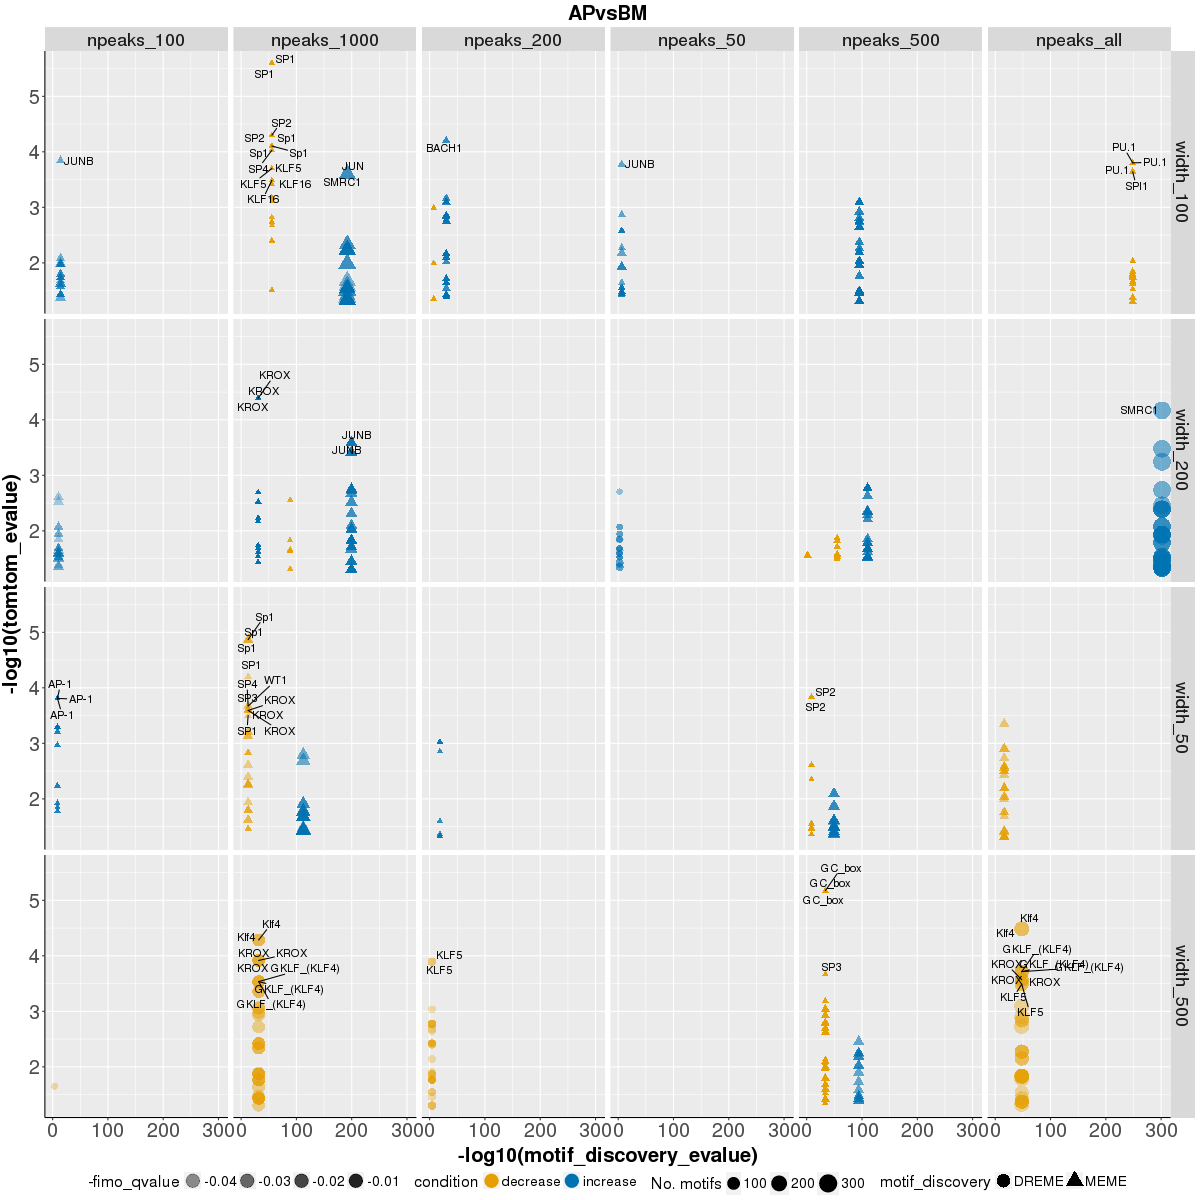

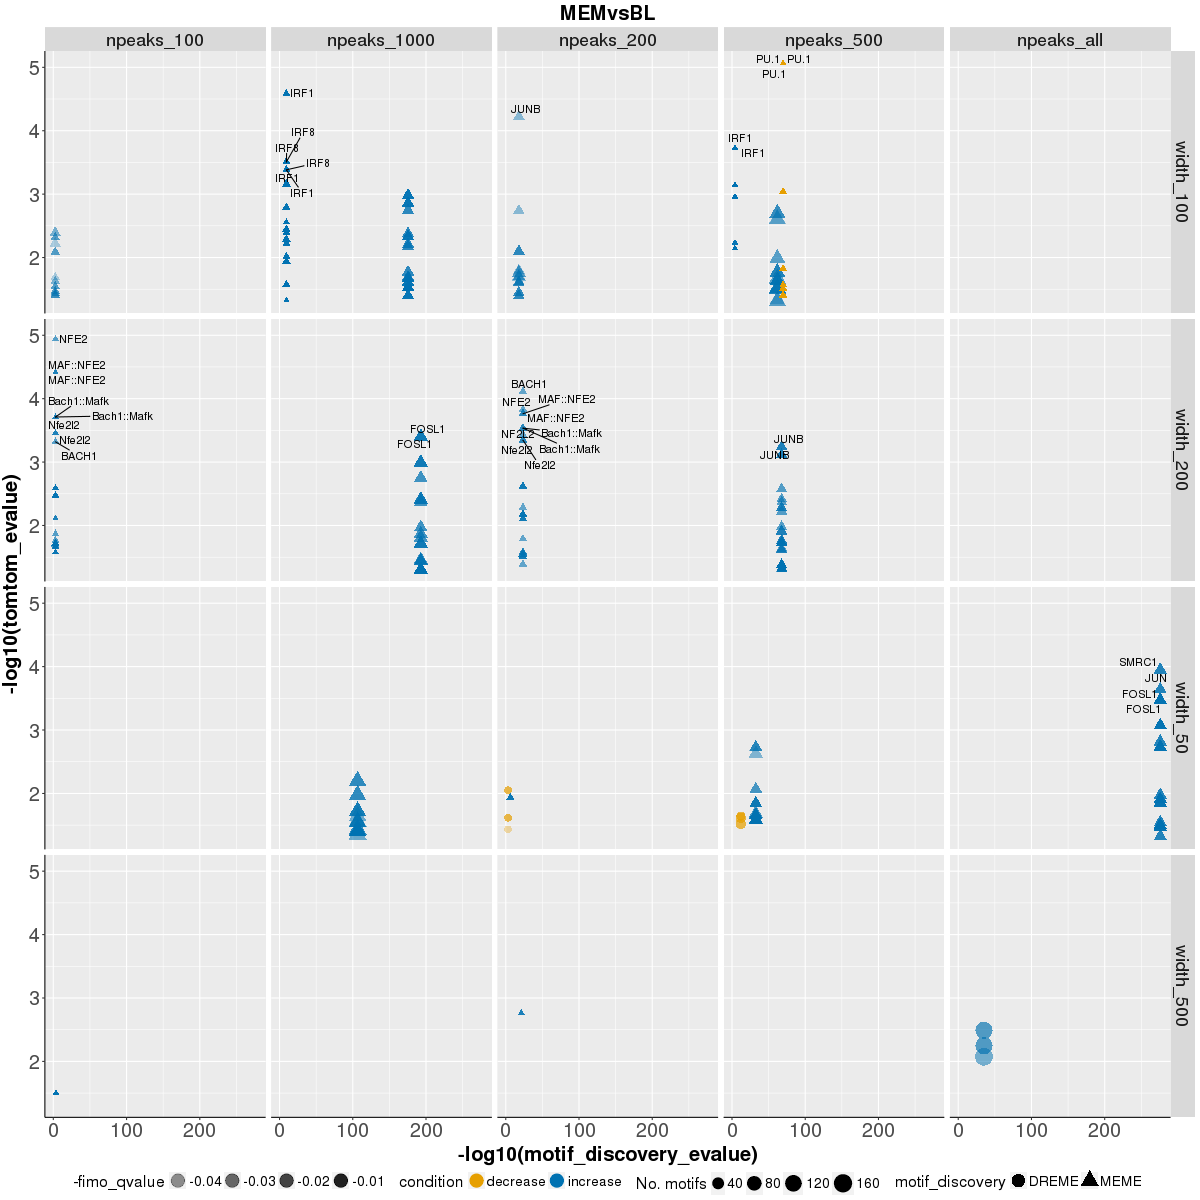

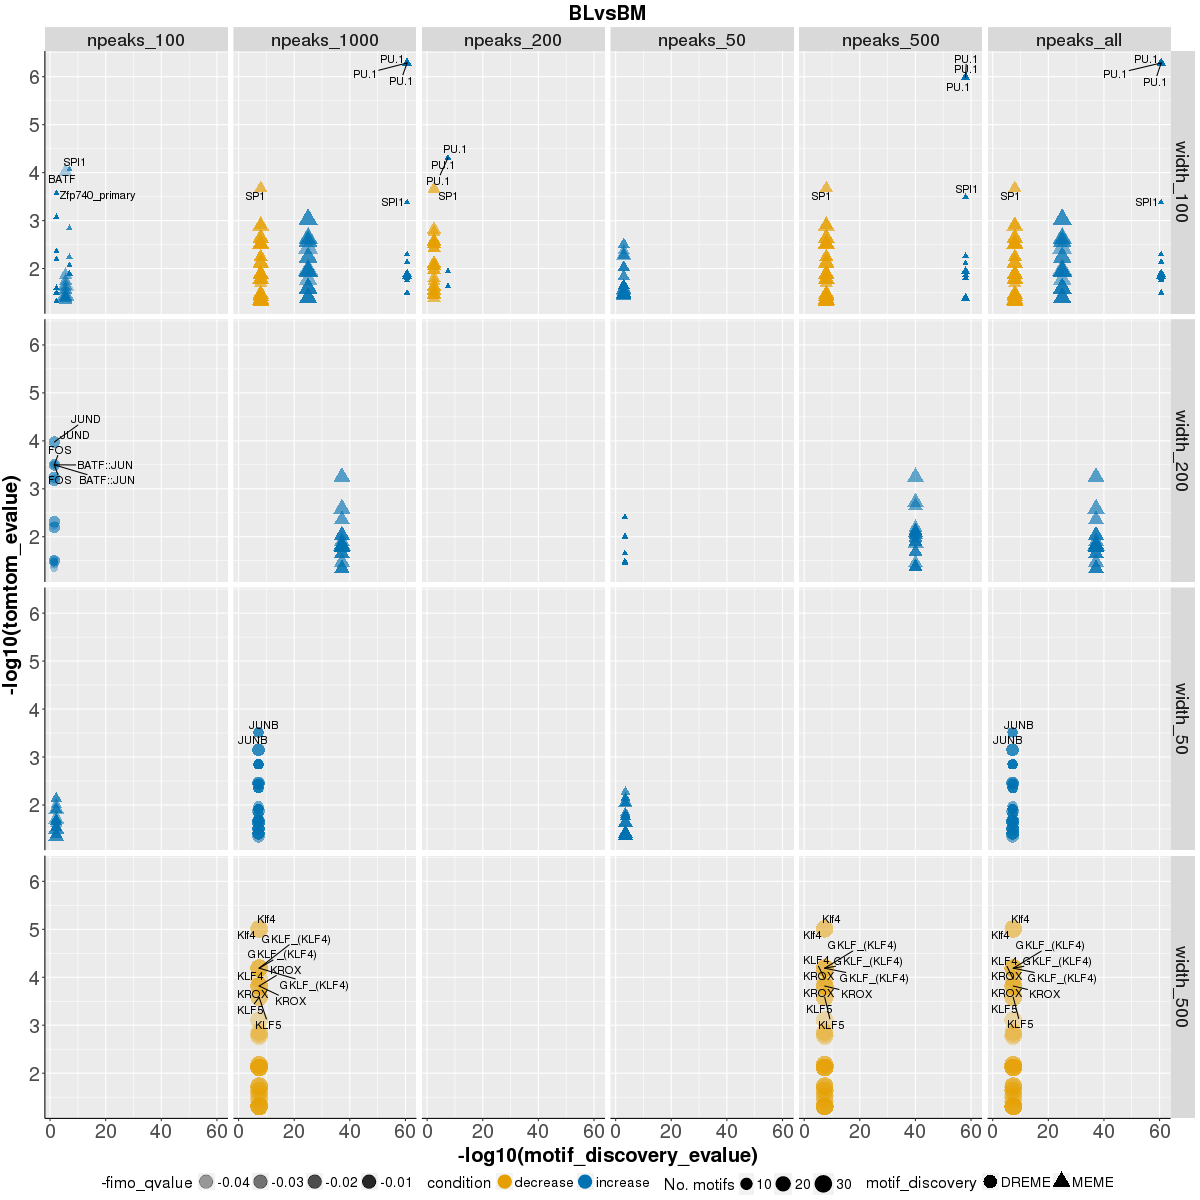

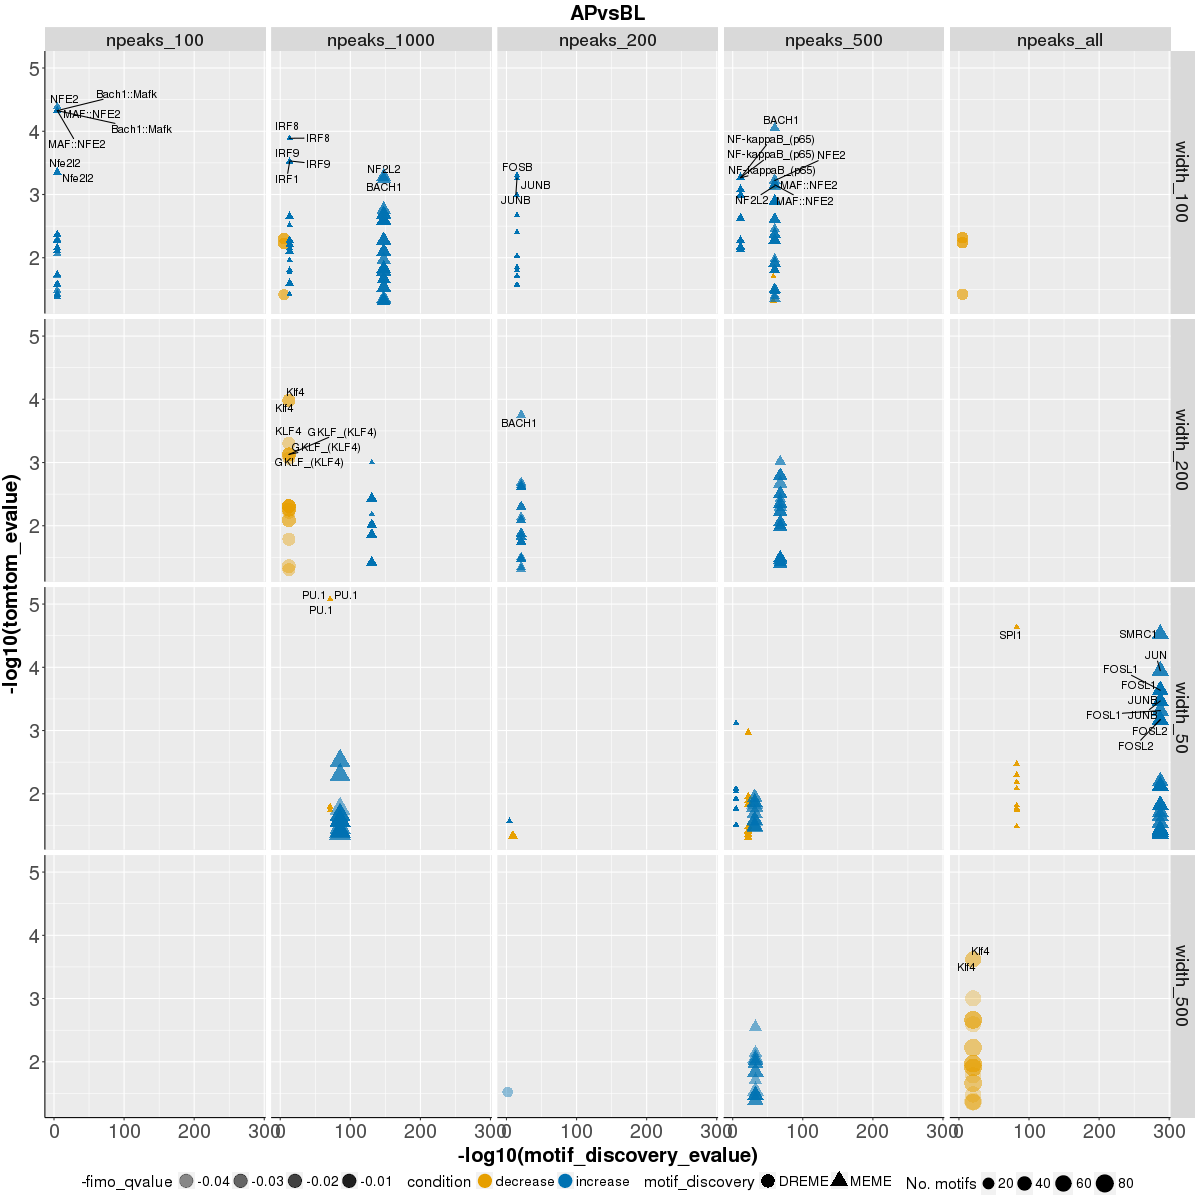

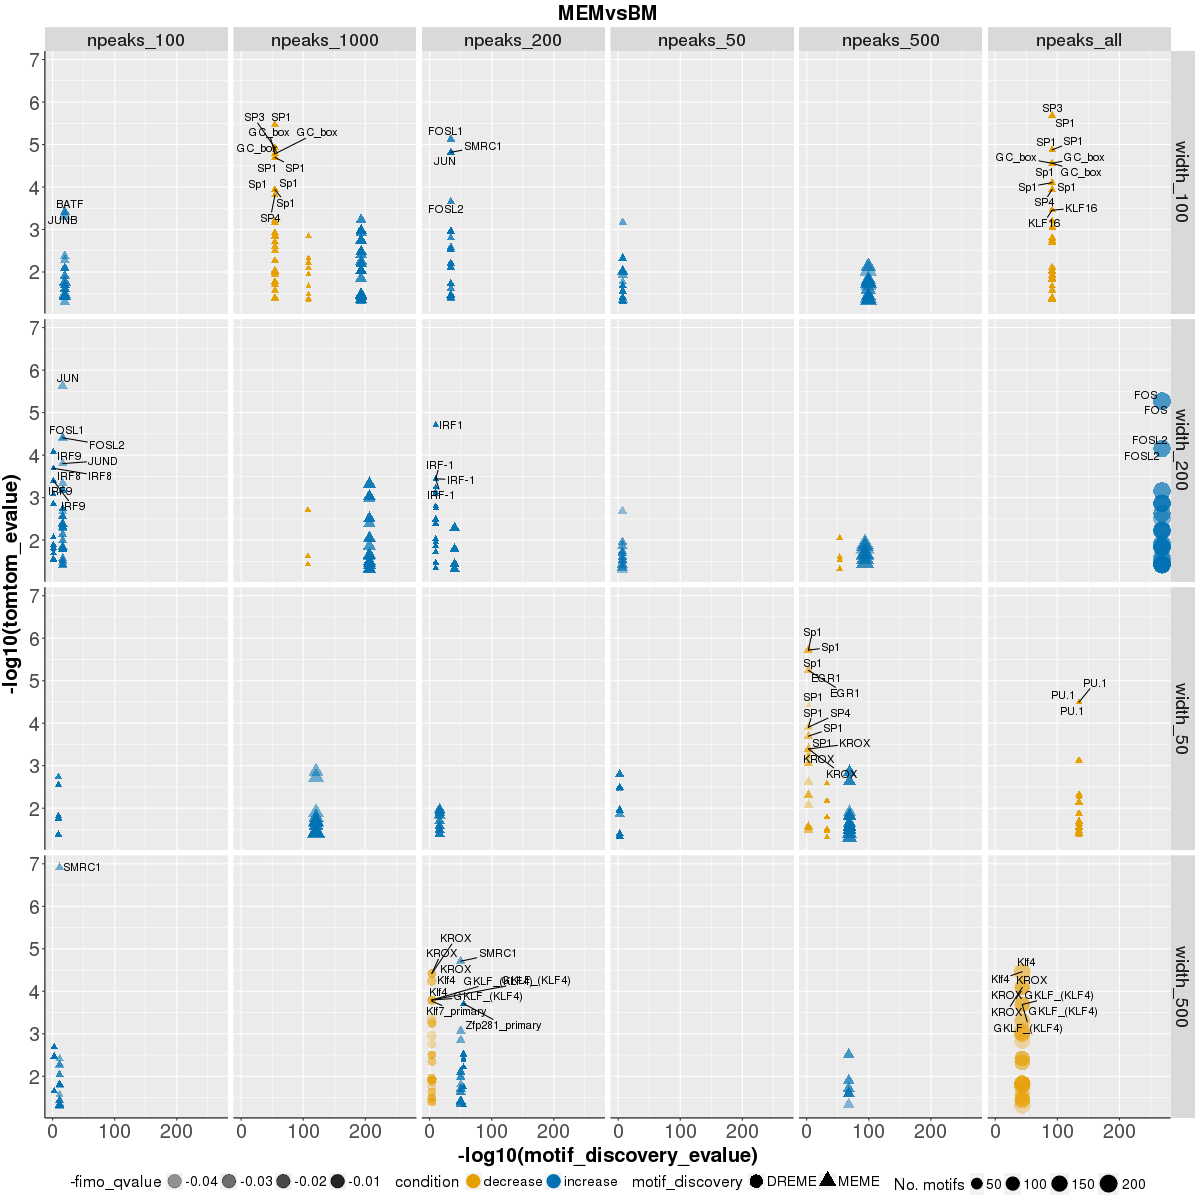

In [15]:
%%R -i fimo_chip -w 1200 -h 1200

for (comp in unique(fimo_chip$DESeq2_comparison)){
    df <- subset(fimo_chip, DESeq2_comparison == comp)

    p <- ggplot(df, aes(y=-log10(tomtom_evalue), x=-log10(motif_discovery_evalue), colour=condition, 
                        shape=motif_discovery, alpha=-fimo_qvalue)) +
        geom_point(aes(size=sequence_name), position=position_jitterdodge()) + 
        scale_size(range=c(2,8), name="No. motifs") +
        scale_alpha(range=c(0.3,1)) +
        geom_text_repel(data=df[-log10(df$tomtom_evalue) > 
                                       quantile(-log10(df$tomtom_evalue), 0.9, na.rm=T), ], 
                        aes(y=-log10(tomtom_evalue), x=-log10(motif_discovery_evalue), label=motif_name), colour="black", alpha=1) +
        facet_grid(width ~ peaks) +
        theme(legend.position="bottom", legend.direction="horizontal") +
        scale_colour_manual(values=Palette) +
        guides(color=guide_legend(override.aes=list(size=6))) +
        guides(alpha=guide_legend(override.aes=list(size=6)))  +
        guides(shape=guide_legend(override.aes=list(size=6)))  +
        labs(title=comp)
    
    grid.arrange(p, ncol=1, nrow=1)
}

***
<br>
### Top TF Matches for Motifs
- The top 5 database TF matches for each motif (discovered by MEME or DREME and found in input sequences by FIMO) are shown
- Numbers over bars indicate the number of instances in which the motif is found by FIMO in the input sequences

In [35]:
tfs = fimo_chip.groupby(["motif", "DESeq2_comparison", "condition", "motif_discovery_evalue", "tomtom_evalue", 
                         "query_consensus", "fimo_qvalue", "settings", "sequence_name"])["motif_name"].unique()
tfs = pd.DataFrame(tfs)
tfs.reset_index(inplace=True)
tfs["motif_name"] = tfs["motif_name"].apply(lambda x:''.join(x))
tfs = tfs.groupby(["motif", "settings"]).head(5) # get top 5 db matches for each discovered motif
tfs["motif"] = tfs["motif"].astype(str)

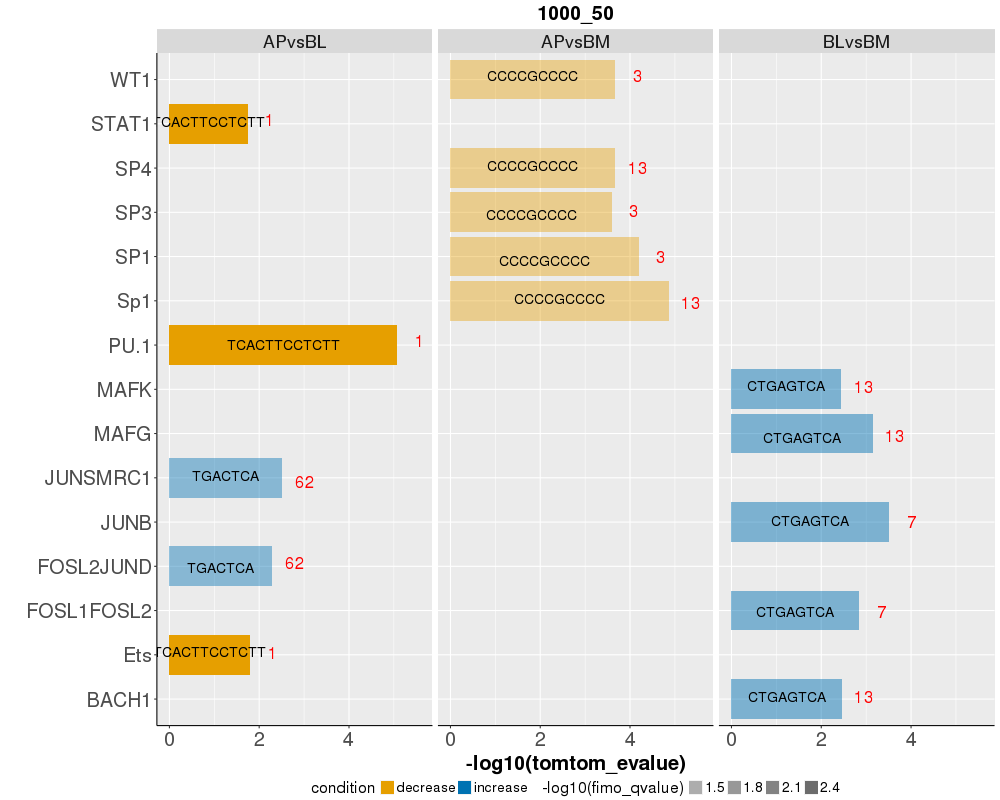

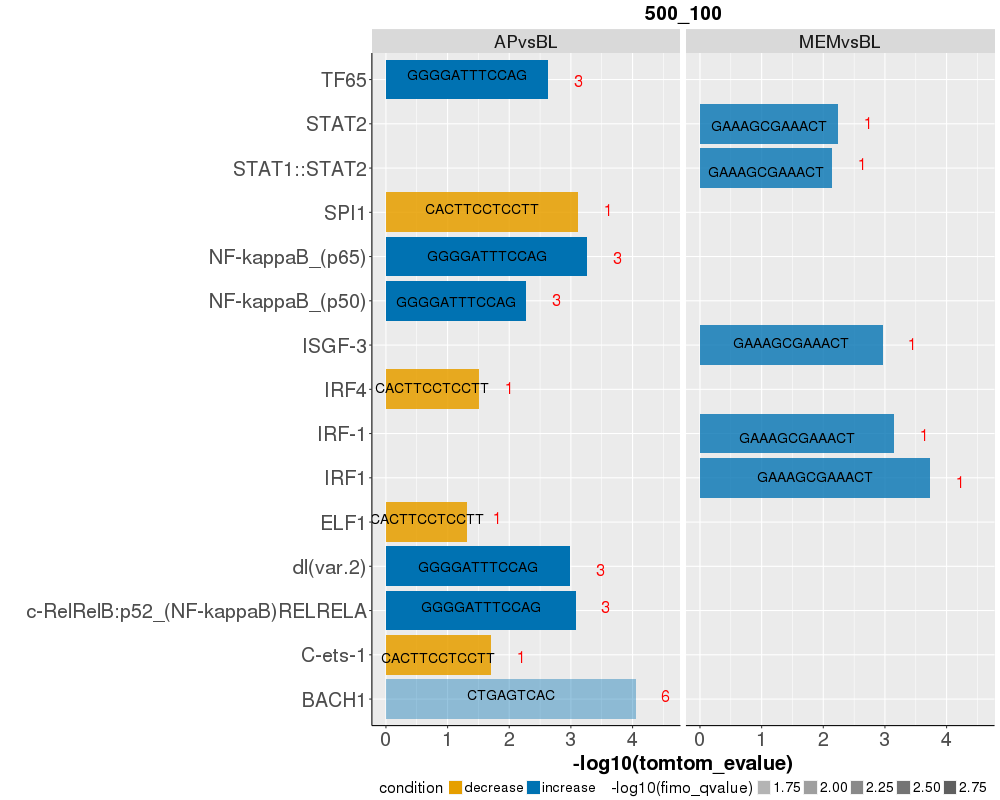

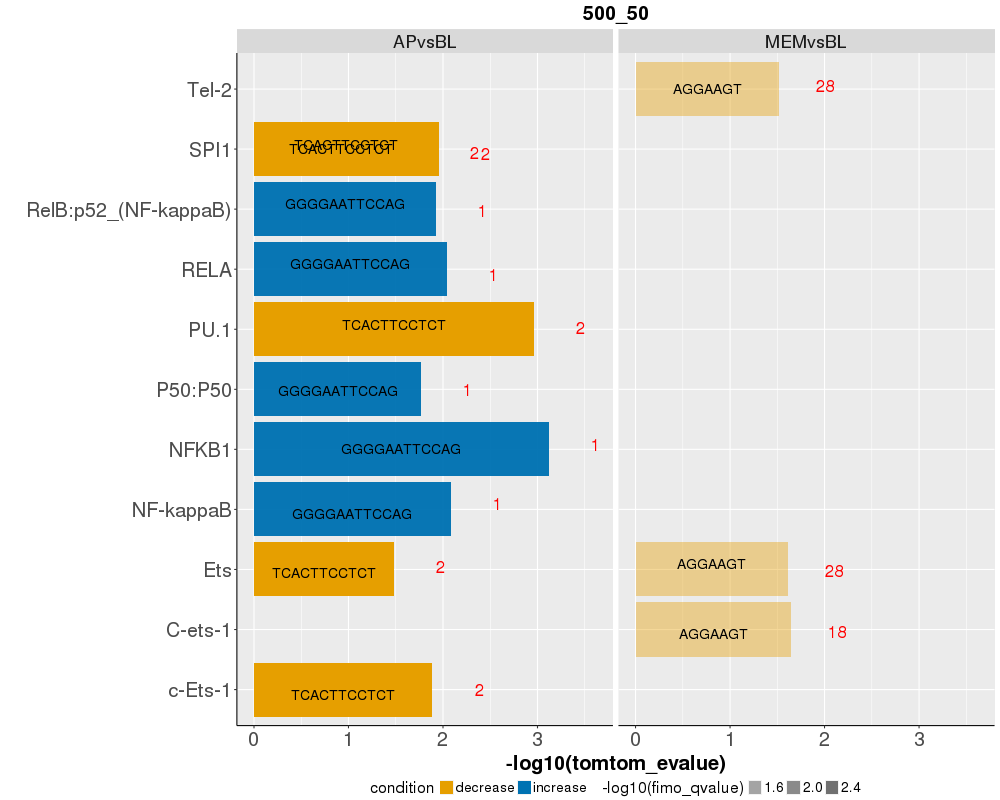

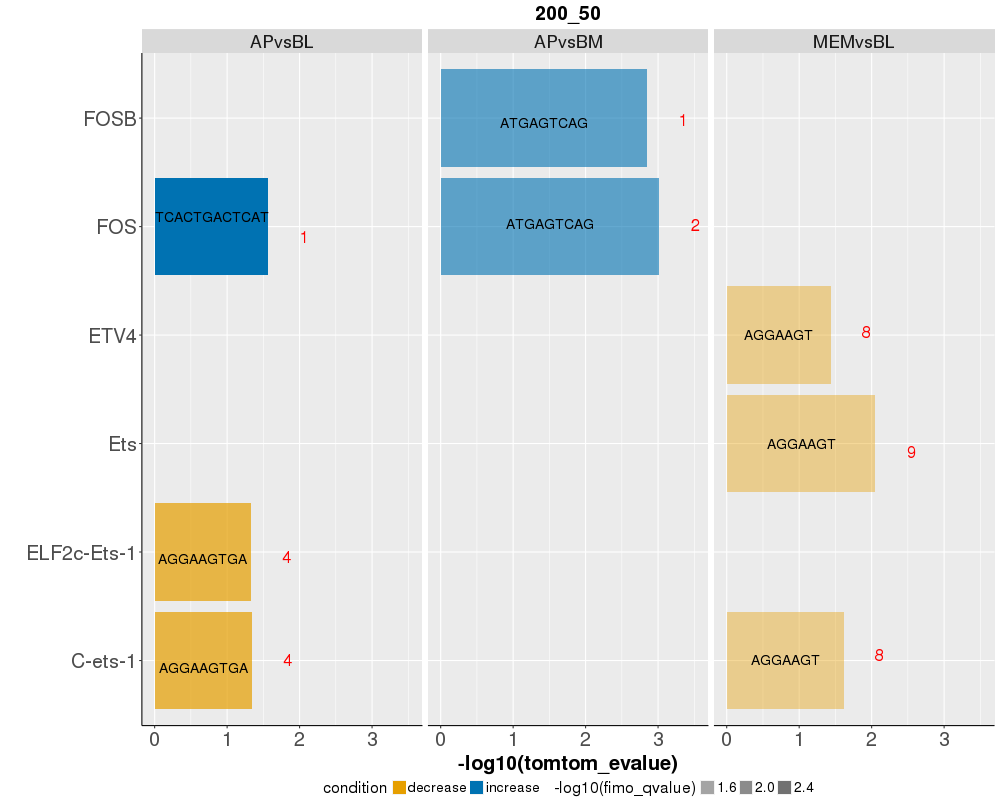

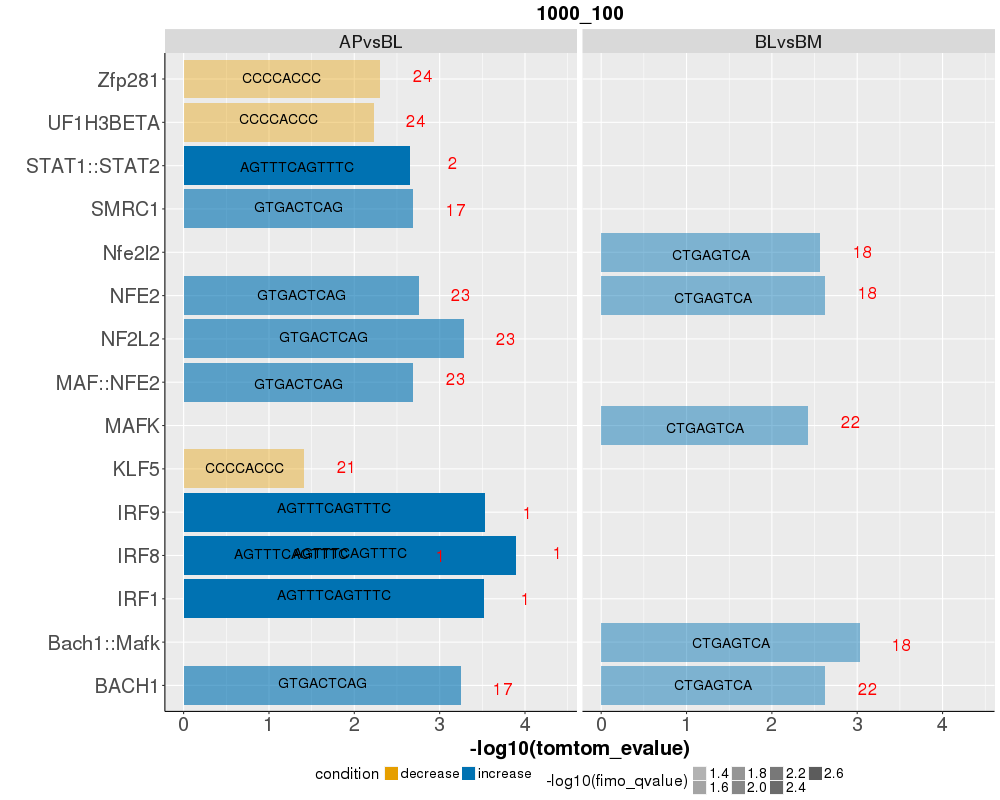

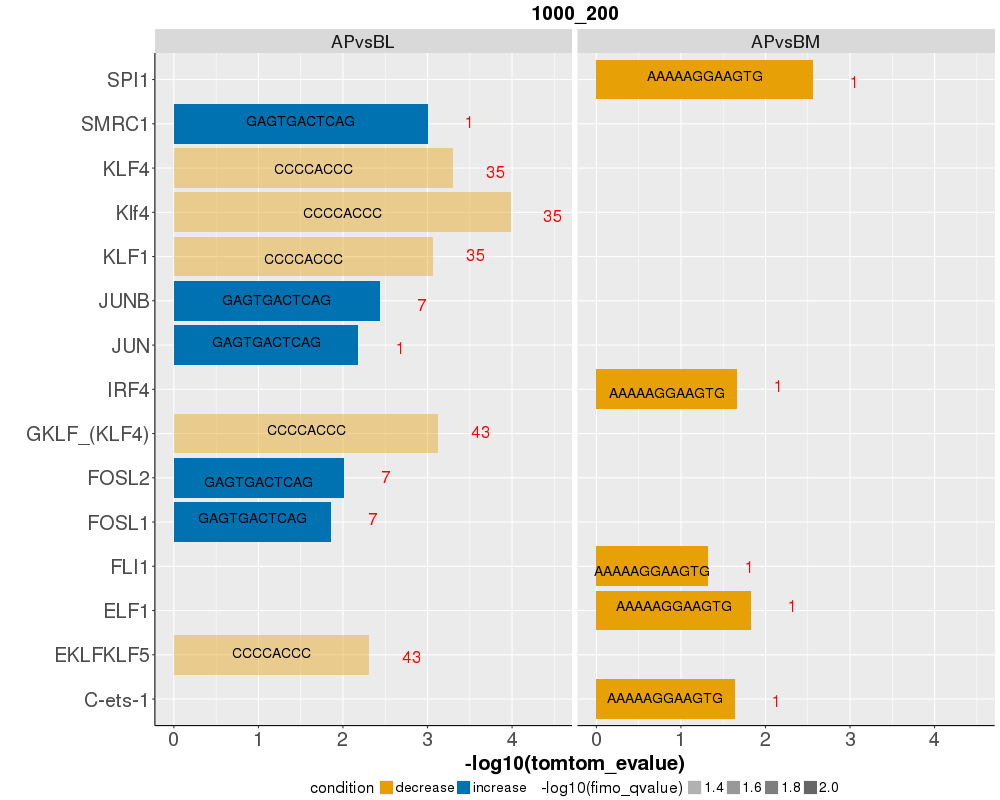

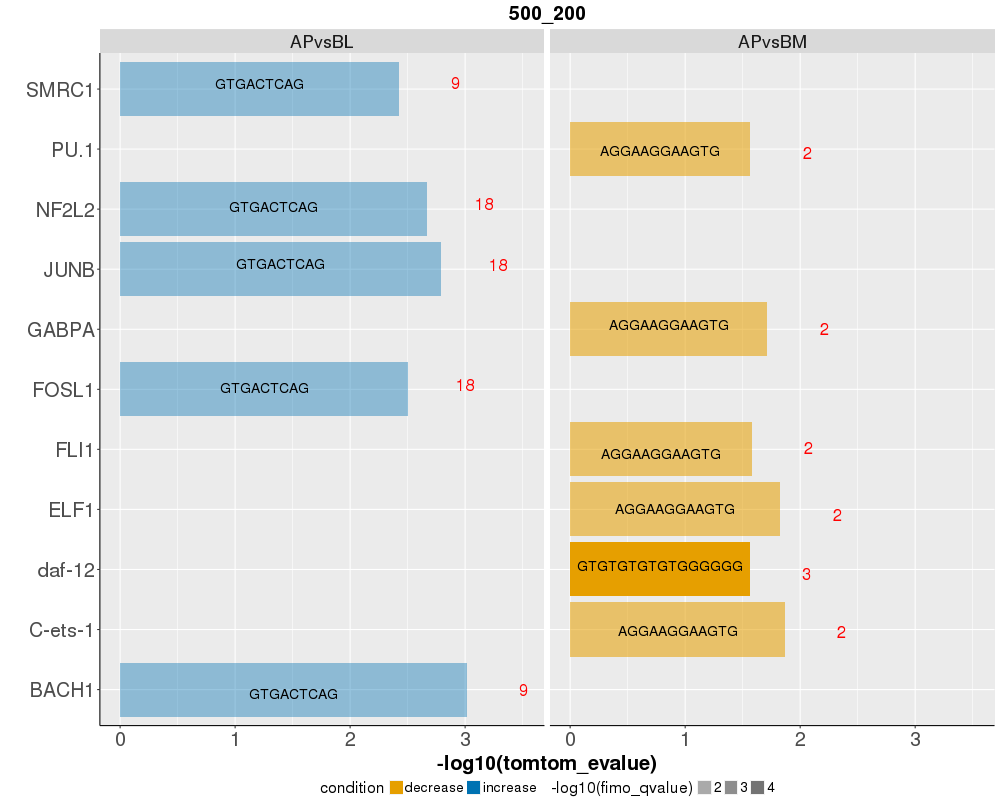

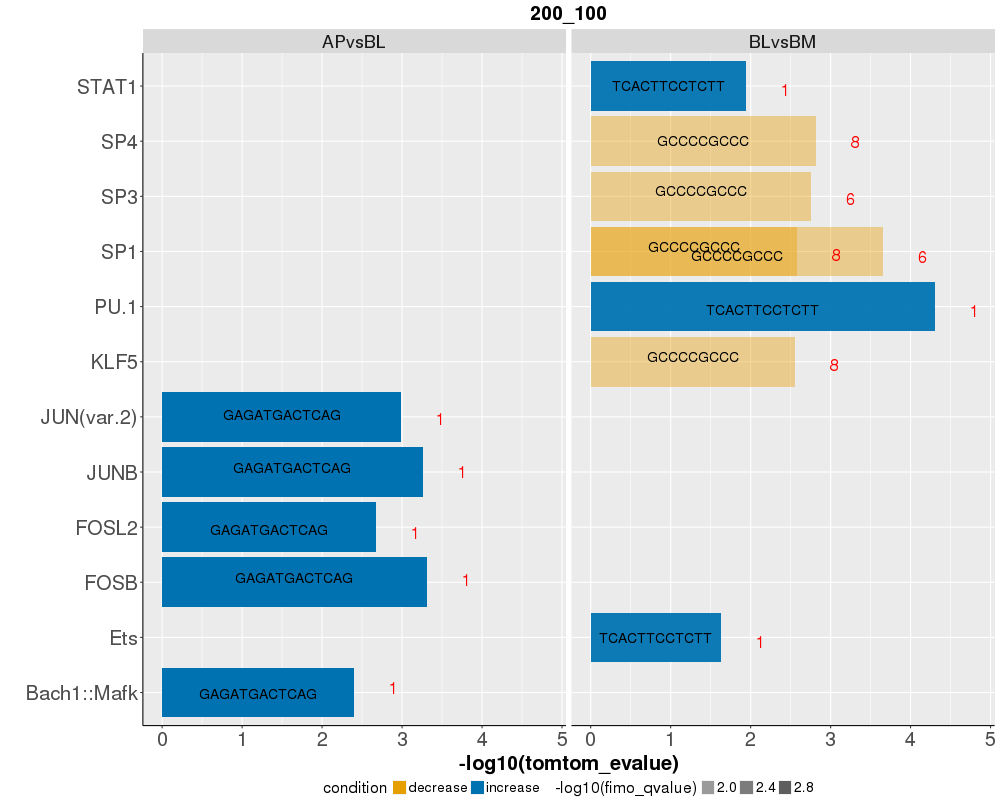

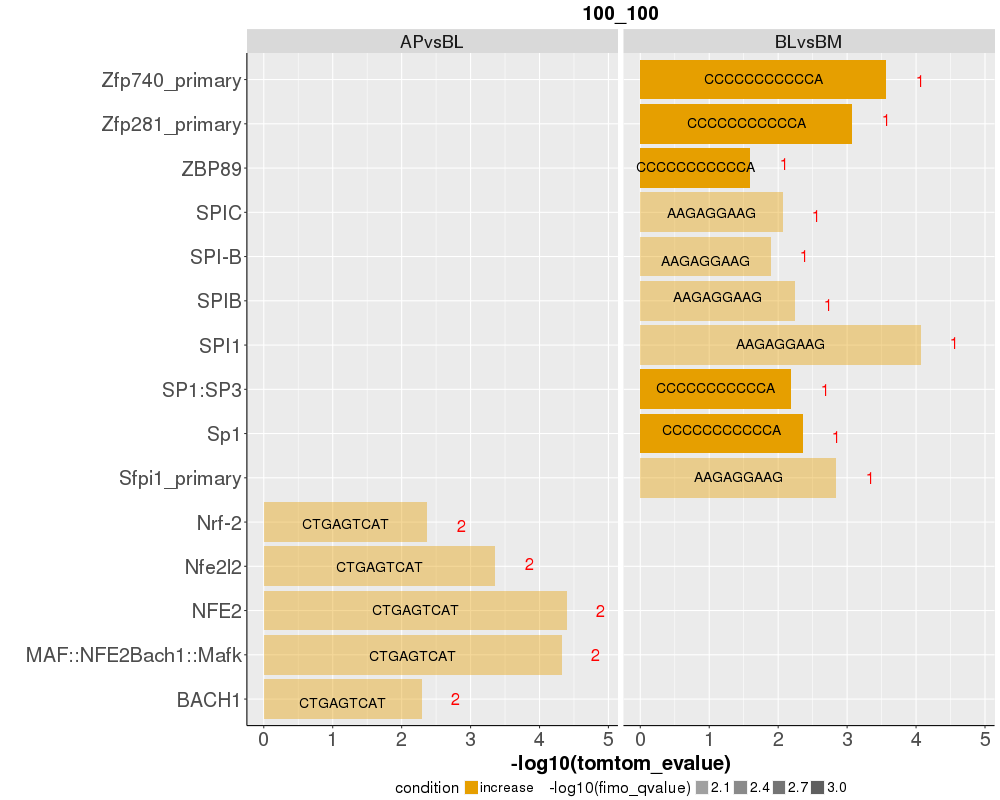

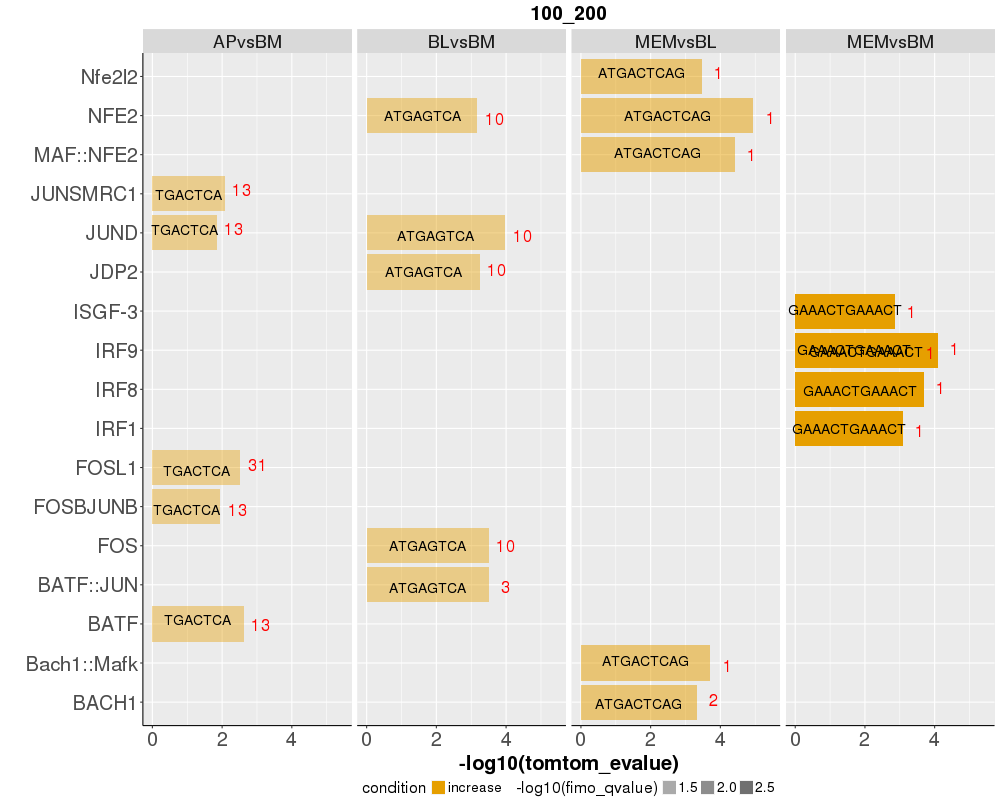

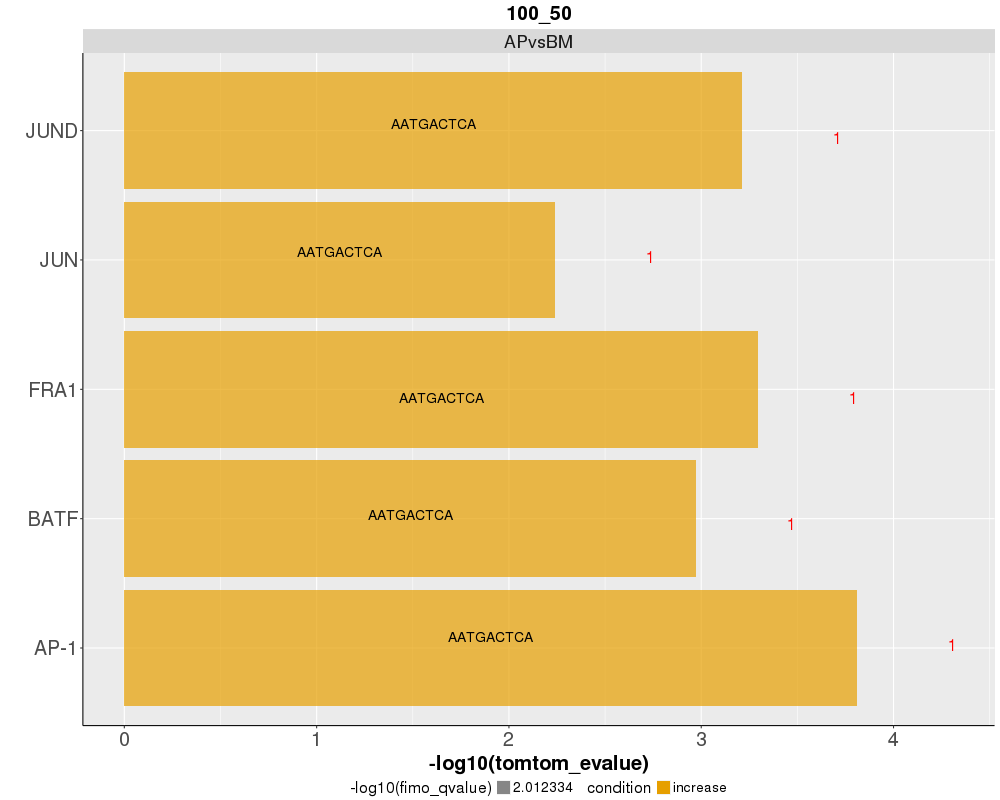

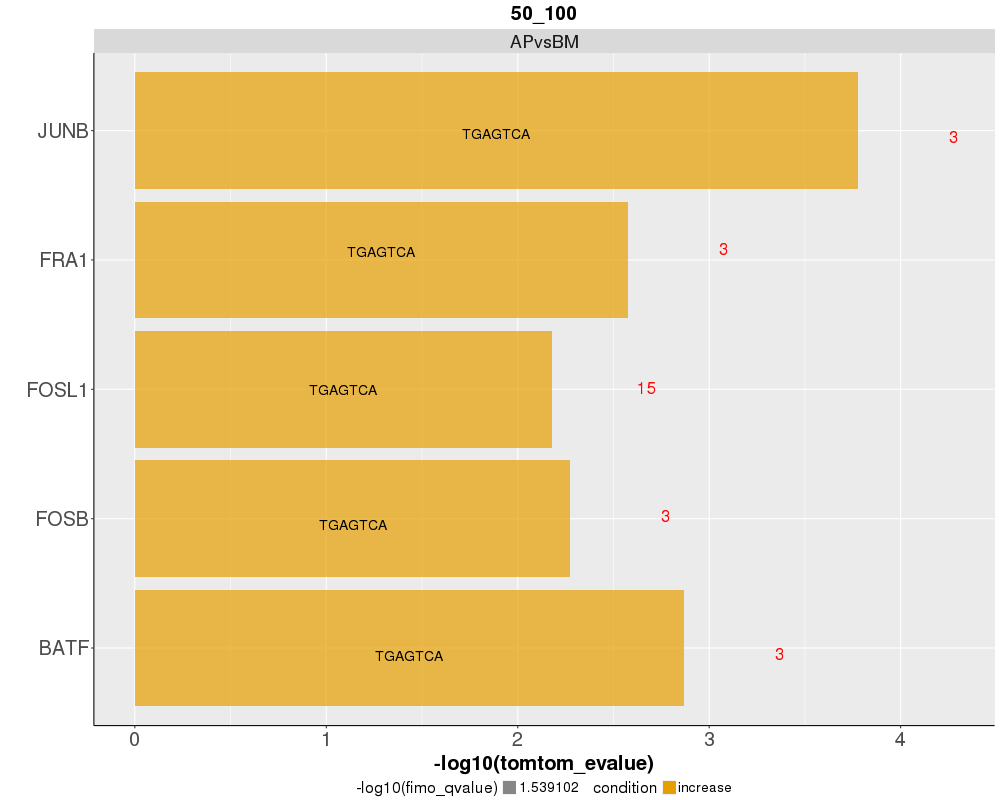

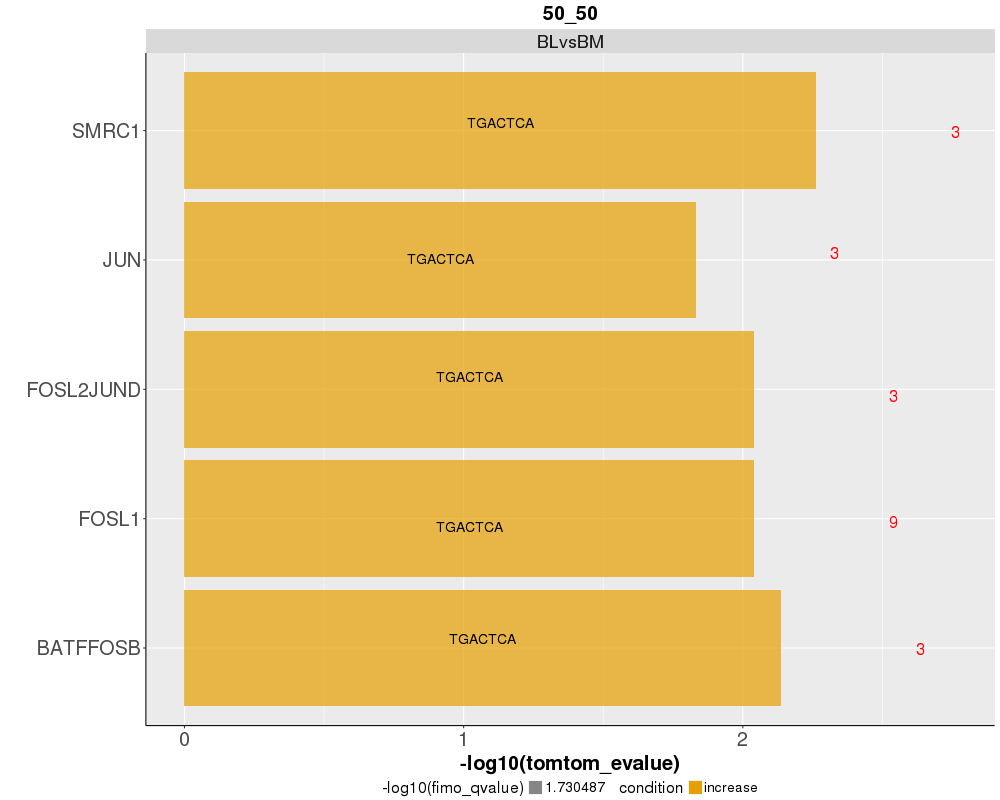

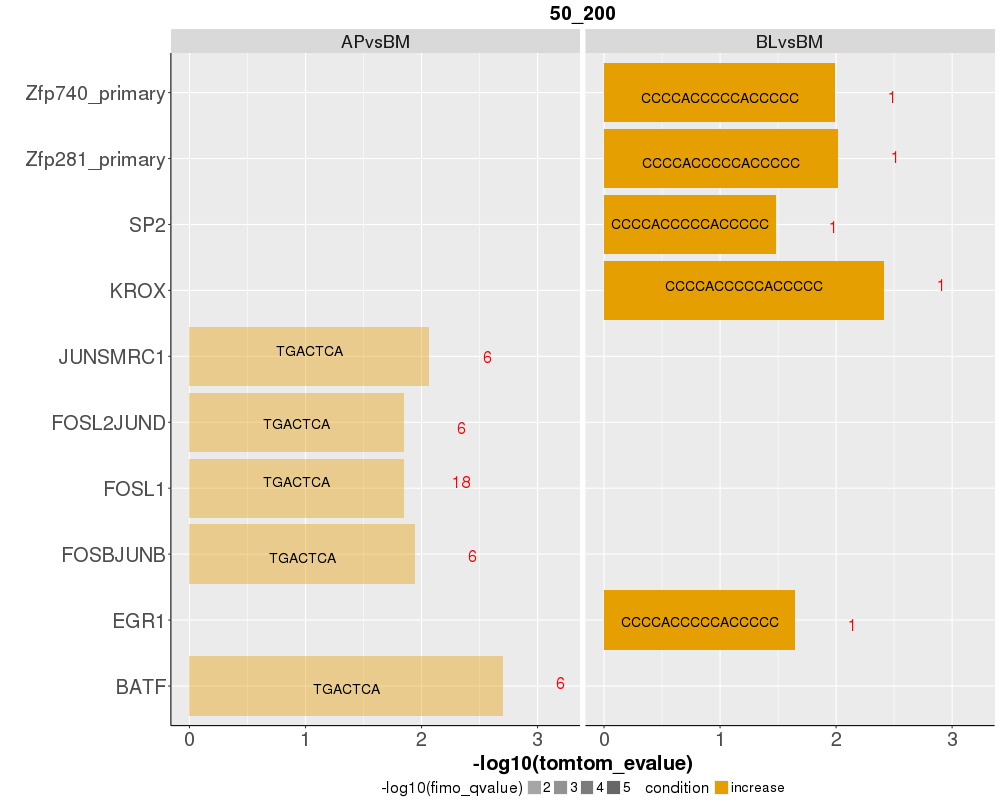

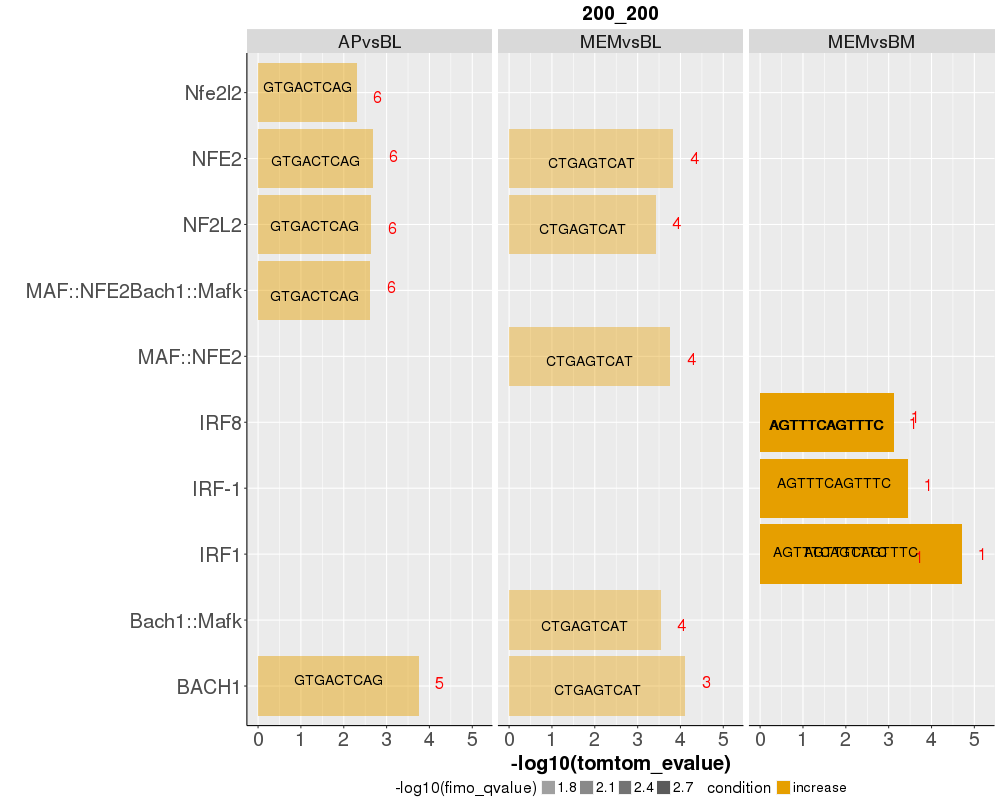

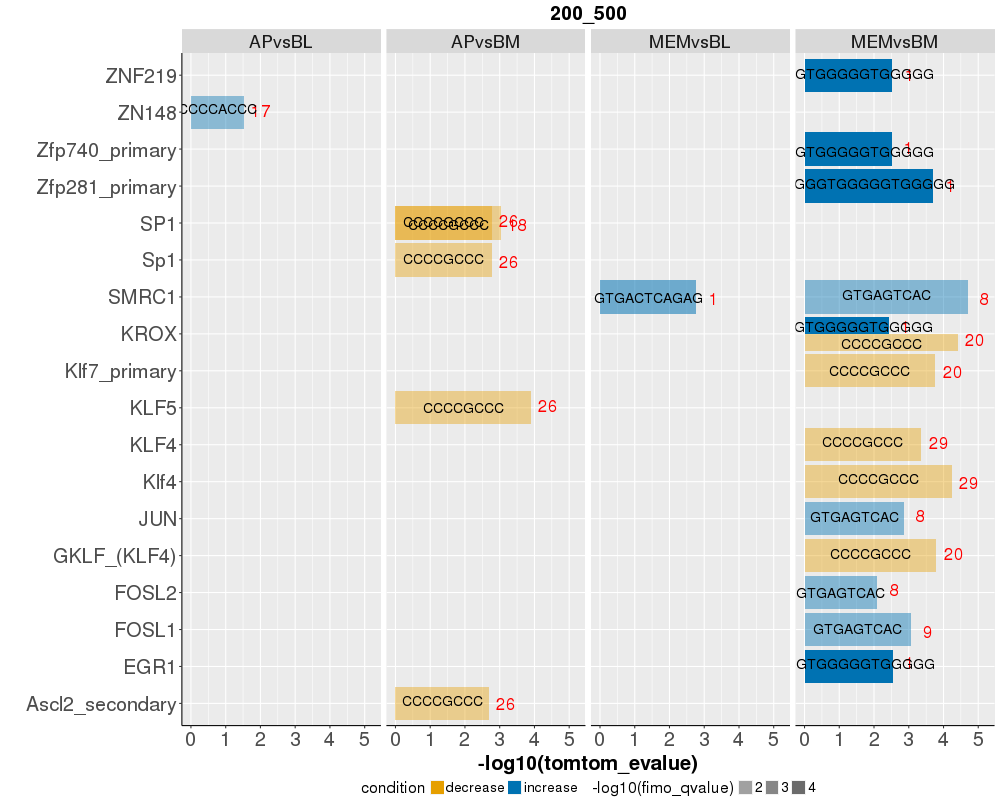

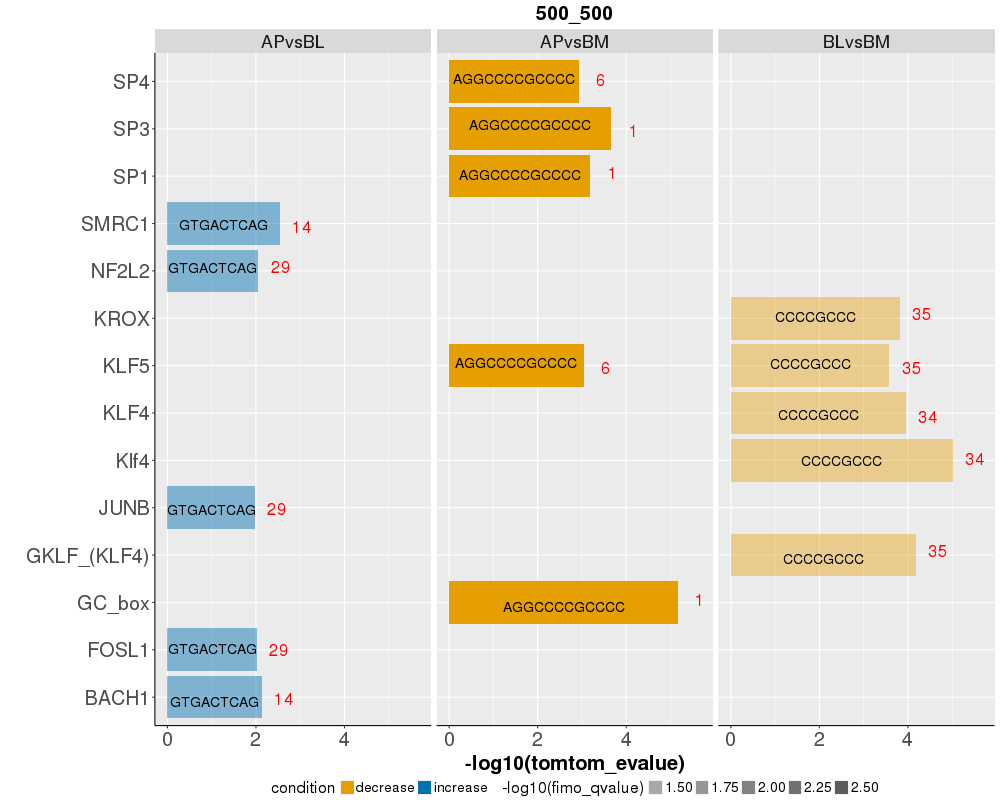

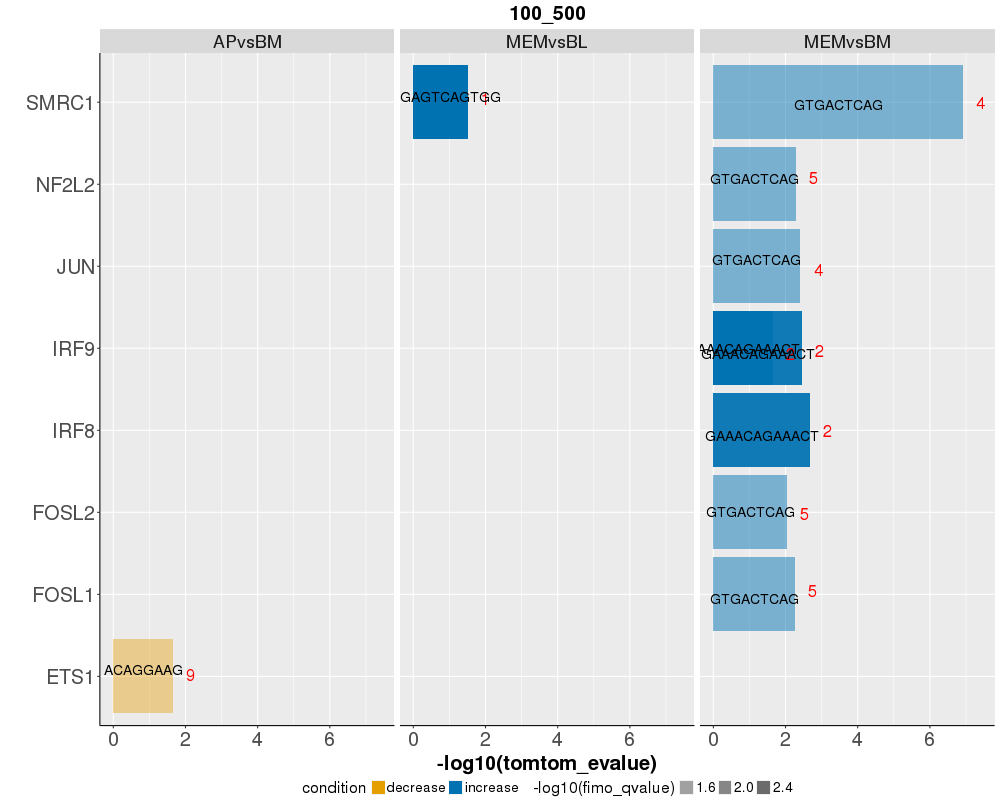

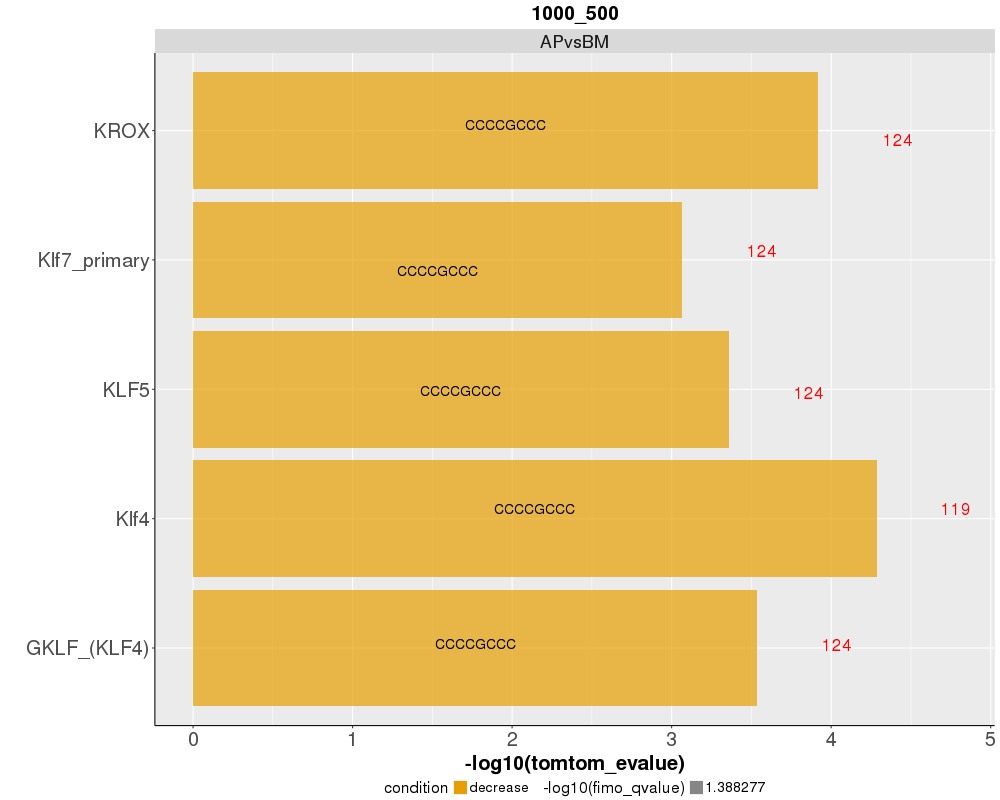

In [38]:
%%R -i tfs -w 1000 -h 800

settings <- unique(tfs$settings)

for (setting in settings){
    p <- ggplot(subset(tfs, settings == setting), 
                aes(y=-log10(tomtom_evalue), x=motif_name, fill=condition, alpha=-log10(fimo_qvalue))) + 
            geom_bar(stat="identity", position="dodge") + 
            geom_text(aes(label=sequence_name, y=-log10(tomtom_evalue)+0.5), size=6, alpha=1, colour="red",
                      position=position_jitterdodge(dodge.width=1)) +
            geom_text(aes(label=query_consensus, y=-log10(tomtom_evalue)/2), size=5, alpha=1, 
                      position=position_jitterdodge(dodge.width=1)) +
            coord_flip() +
            scale_alpha(range=c(0.4,1 )) +
            facet_wrap( ~ DESeq2_comparison, nrow=1) +
            scale_fill_manual(values=Palette) +
            theme(legend.position="bottom", legend.direction="horizontal") +
            labs(title=setting, x="")

    grid.arrange(p, ncol=1, nrow=1)
}

<br>
## Top Motif Tables:
* sorted by peak size & fimo q-value

### Peaks with increased accessibility:

In [18]:
for i in fimo_chip["DESeq2_comparison"].unique():
    print i
    fimo_chip[(fimo_chip.DESeq2_comparison == i) & (fimo_chip.condition == "increase")].sort_values(["width", "fimo_qvalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

APvsBM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1144,584,CTGAGTCAC,1,+,7.100000e-96,0.001196,BACH1_MOUSE.H10MO.C,BACH1,hocomoco,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1145,585,CTGAGTCAC,1,+,7.100000e-96,0.001552,SMRC1_MOUSE.H10MO.B,SMRC1,hocomoco,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1146,586,CTGAGTCAC,1,+,7.100000e-96,0.004255,JUN_MOUSE.H10MO.A,JUN,hocomoco,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1147,587,CTGAGTCAC,1,+,7.100000e-96,0.034465,M00821,Nrf-2,jaspar,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1150,590,CTGAGTCAC,1,+,7.100000e-96,0.048372,JUND_MOUSE.H10MO.A,JUND,hocomoco,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,13,MEME,width_100,npeaks_500
1255,695,CTGAGTCAC,1,-,7.100000e-96,0.000805,MA0490.1,JUNB,jaspar,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1257,697,CTGAGTCAC,1,-,7.100000e-96,0.001781,MA0477.1,FOSL1,jaspar,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1259,699,CTGAGTCAC,1,-,7.100000e-96,0.001852,NF2L2_MOUSE.H10MO.D,NF2L2,hocomoco,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1260,700,CTGAGTCAC,1,-,7.100000e-96,0.002234,MA0478.1,FOSL2,jaspar,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500
1262,702,CTGAGTCAC,1,-,7.100000e-96,0.005496,NFE2_MOUSE.H10MO.A,NFE2,hocomoco,APvsBM,increase,APvsBM_increase_500_100,500_100,0.0116,15.5584,12,MEME,width_100,npeaks_500


MEMvsBL


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
640,80,ACTTTCAGTTTC,3,+,4.300000e-10,0.000415,MA0050.2,IRF1,jaspar,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
642,82,ACTTTCAGTTTC,3,+,4.300000e-10,0.000659,M01881,IRF-1,jaspar,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
645,85,ACTTTCAGTTTC,3,+,4.300000e-10,0.002751,STAT2_MOUSE.H10MO.B,STAT2,hocomoco,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
646,86,ACTTTCAGTTTC,3,+,4.300000e-10,0.004051,MA0517.1,STAT1::STAT2,jaspar,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
648,88,ACTTTCAGTTTC,3,+,4.300000e-10,0.026017,M00258,ISGF-3,jaspar,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
651,91,ACTTTCAGTTTC,3,+,4.300000e-10,0.047551,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,1,MEME,width_100,npeaks_1000
652,92,ACTTTCAGTTTC,3,-,4.300000e-10,0.000026,IRF1_MOUSE.H10MO.C,IRF1,hocomoco,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000
653,93,ACTTTCAGTTTC,3,-,4.300000e-10,0.000310,MA0652.1,IRF8,jaspar,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000
655,95,ACTTTCAGTTTC,3,-,4.300000e-10,0.000414,IRF8_MOUSE.H10MO.D,IRF8,hocomoco,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000
656,96,ACTTTCAGTTTC,3,-,4.300000e-10,0.000696,IRF7_MOUSE.H10MO.C,IRF7,hocomoco,MEMvsBL,increase,MEMvsBL_increase_1000_100,1000_100,0.00232,20.1,3,MEME,width_100,npeaks_1000


BLvsBM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1002,442,CCCCCCCCCCCA,3,+,5.000000e-03,0.000272,UP00022_1,Zfp740_primary,uniprobe,BLvsBM,increase,BLvsBM_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
1003,443,CCCCCCCCCCCA,3,+,5.000000e-03,0.000848,UP00021_1,Zfp281_primary,uniprobe,BLvsBM,increase,BLvsBM_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
1004,444,CCCCCCCCCCCA,3,+,5.000000e-03,0.004426,M00933,Sp1,jaspar,BLvsBM,increase,BLvsBM_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
1007,447,CCCCCCCCCCCA,3,+,5.000000e-03,0.006462,M01219,SP1:SP3,jaspar,BLvsBM,increase,BLvsBM_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
1010,450,CCCCCCCCCCCA,3,+,5.000000e-03,0.025449,M01816,ZBP89,jaspar,BLvsBM,increase,BLvsBM_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
1013,453,CCCCCCCCCCCA,3,+,5.000000e-03,0.032078,MA0753.1,ZNF740,jaspar,BLvsBM,increase,BLvsBM_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
1015,455,CCCCCCCCCCCA,3,+,5.000000e-03,0.048660,MA0079.3,SP1,jaspar,BLvsBM,increase,BLvsBM_increase_100_100,100_100,0.000847,19.9495,1,MEME,width_100,npeaks_100
2257,1697,TCACTTCCTCTT,1,+,9.200000e-59,0.000001,M01172,PU.1,jaspar,BLvsBM,increase,BLvsBM_increase_500_100,500_100,0.001460,18.6053,2,MEME,width_100,npeaks_500
2260,1700,TCACTTCCTCTT,1,+,9.200000e-59,0.011535,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,BLvsBM,increase,BLvsBM_increase_500_100,500_100,0.001460,18.6053,2,MEME,width_100,npeaks_500
2261,1701,TCACTTCCTCTT,1,+,9.200000e-59,0.041866,M00971,Ets,jaspar,BLvsBM,increase,BLvsBM_increase_500_100,500_100,0.001460,18.6053,2,MEME,width_100,npeaks_500


APvsBL


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1447,887,GAGATGACTCAG,1,+,9.700000e-16,0.000493,FOSB_MOUSE.H10MO.C,FOSB,hocomoco,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1448,888,GAGATGACTCAG,1,+,9.700000e-16,0.000551,MA0490.1,JUNB,jaspar,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1450,890,GAGATGACTCAG,1,+,9.700000e-16,0.001020,MA0489.1,JUN(var.2),jaspar,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1452,892,GAGATGACTCAG,1,+,9.700000e-16,0.002133,MA0478.1,FOSL2,jaspar,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1454,894,GAGATGACTCAG,1,+,9.700000e-16,0.003943,MA0591.1,Bach1::Mafk,jaspar,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1456,896,GAGATGACTCAG,1,+,9.700000e-16,0.009363,MA0462.1,BATF::JUN,jaspar,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1458,898,GAGATGACTCAG,1,+,9.700000e-16,0.014250,MA0303.1,GCN4,jaspar,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1460,900,GAGATGACTCAG,1,+,9.700000e-16,0.015947,MA0477.1,FOSL1,jaspar,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1462,902,GAGATGACTCAG,1,+,9.700000e-16,0.019420,JUNB_MOUSE.H10MO.B,JUNB,hocomoco,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200
1463,903,GAGATGACTCAG,1,+,9.700000e-16,0.026629,FOSL2_MOUSE.H10MO.A,FOSL2,hocomoco,APvsBL,increase,APvsBL_increase_200_100,200_100,0.00136,17.5904,1,MEME,width_100,npeaks_200


MEMvsBM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1130,570,CTGAGTCAC,1,+,5.500000e-194,0.000600,SMRC1_MOUSE.H10MO.B,SMRC1,hocomoco,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1131,571,CTGAGTCAC,1,+,5.500000e-194,0.001186,BACH1_MOUSE.H10MO.C,BACH1,hocomoco,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1132,572,CTGAGTCAC,1,+,5.500000e-194,0.003832,JUN_MOUSE.H10MO.A,JUN,hocomoco,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1133,573,CTGAGTCAC,1,+,5.500000e-194,0.037806,M00821,Nrf-2,jaspar,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1136,576,CTGAGTCAC,1,+,5.500000e-194,0.041144,JUND_MOUSE.H10MO.A,JUND,hocomoco,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1137,577,CTGAGTCAC,1,+,5.500000e-194,0.048148,FOSL2_MOUSE.H10MO.A,FOSL2,hocomoco,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,19,MEME,width_100,npeaks_1000
1195,635,CTGAGTCAC,1,-,5.500000e-194,0.001069,NF2L2_MOUSE.H10MO.D,NF2L2,hocomoco,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000
1196,636,CTGAGTCAC,1,-,5.500000e-194,0.001071,MA0490.1,JUNB,jaspar,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000
1198,638,CTGAGTCAC,1,-,5.500000e-194,0.001801,MA0478.1,FOSL2,jaspar,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000
1200,640,CTGAGTCAC,1,-,5.500000e-194,0.003345,MA0477.1,FOSL1,jaspar,MEMvsBM,increase,MEMvsBM_increase_1000_100,1000_100,0.0137,15.2113,22,MEME,width_100,npeaks_1000


### Peaks with decreased accessibility:

In [19]:
for i in fimo_chip["DESeq2_comparison"].unique():
    print i
    fimo_chip[(fimo_chip.DESeq2_comparison == i) & (fimo_chip.condition == "decrease")].sort_values(["width", "fimo_qvalue"], ascending=True).drop_duplicates(["target_id", "motif_name", "orientation"], keep="first").head(10)

APvsBM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
892,332,CACTCACTTCCT,1,-,5.100000e-08,0.001022,M00339,c-Ets-1,jaspar,APvsBM,decrease,APvsBM_decrease_200_100,200_100,0.00163,19.3258,1,MEME,width_100,npeaks_200
895,335,CACTCACTTCCT,1,-,5.100000e-08,0.010104,ELF2_MOUSE.H10MO.C,ELF2,hocomoco,APvsBM,decrease,APvsBM_decrease_200_100,200_100,0.00163,19.3258,1,MEME,width_100,npeaks_200
896,336,CACTCACTTCCT,1,-,5.100000e-08,0.044049,M01870,C-ets-1,jaspar,APvsBM,decrease,APvsBM_decrease_200_100,200_100,0.00163,19.3258,1,MEME,width_100,npeaks_200
919,359,CACTTCCTCTTT,1,+,2.500000e-249,0.000158,M01172,PU.1,jaspar,APvsBM,decrease,APvsBM_decrease_all_100,all_100,0.00421,17.9545,1,MEME,width_100,npeaks_all
922,362,CACTTCCTCTTT,1,+,2.500000e-249,0.009222,M00971,Ets,jaspar,APvsBM,decrease,APvsBM_decrease_all_100,all_100,0.00421,17.9545,1,MEME,width_100,npeaks_all
925,365,CACTTCCTCTTT,1,+,2.500000e-249,0.029826,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,APvsBM,decrease,APvsBM_decrease_all_100,all_100,0.00421,17.9545,1,MEME,width_100,npeaks_all
926,366,CACTTCCTCTTT,1,-,2.500000e-249,0.000229,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,APvsBM,decrease,APvsBM_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
927,367,CACTTCCTCTTT,1,-,2.500000e-249,0.014497,UP00085_1,Sfpi1_primary,uniprobe,APvsBM,decrease,APvsBM_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
931,371,CACTTCCTCTTT,1,-,2.500000e-249,0.017051,IRF4_MOUSE.H10MO.C,IRF4,hocomoco,APvsBM,decrease,APvsBM_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all
932,372,CACTTCCTCTTT,1,-,2.500000e-249,0.018274,M01203,SPI1_(PU1),jaspar,APvsBM,decrease,APvsBM_decrease_all_100,all_100,0.00421,17.9545,3,MEME,width_100,npeaks_all


MEMvsBL


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
607,47,AAGAGGAAGTGA,1,+,1.800000e-70,0.000911,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
608,48,AAGAGGAAGTGA,1,+,1.800000e-70,0.014900,M02078,SPI1,transfac,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
609,49,AAGAGGAAGTGA,1,+,1.800000e-70,0.027260,UP00085_1,Sfpi1_primary,uniprobe,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
610,50,AAGAGGAAGTGA,1,+,1.800000e-70,0.030441,M02076,Spi-B,jaspar,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
613,53,AAGAGGAAGTGA,1,+,1.800000e-70,0.030441,M02077,Spic,jaspar,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
616,56,AAGAGGAAGTGA,1,+,1.800000e-70,0.031524,IRF4_MOUSE.H10MO.C,IRF4,hocomoco,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
617,57,AAGAGGAAGTGA,1,+,1.800000e-70,0.038636,ELF2_MOUSE.H10MO.C,ELF2,hocomoco,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
618,58,AAGAGGAAGTGA,1,+,1.800000e-70,0.039728,M01870,C-ets-1,jaspar,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,2,MEME,width_100,npeaks_500
621,61,AAGAGGAAGTGA,1,-,1.800000e-70,0.000009,M01172,PU.1,jaspar,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,1,MEME,width_100,npeaks_500
624,64,AAGAGGAAGTGA,1,-,1.800000e-70,0.026115,STAT1_MOUSE.H10MO.A,STAT1,hocomoco,MEMvsBL,decrease,MEMvsBL_decrease_500_100,500_100,0.00137,18.1558,1,MEME,width_100,npeaks_500


BLvsBM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1476,916,GCCCCGCCC,1,+,1.100000e-08,0.001280,M01273,SP4,transfac,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1479,919,GCCCCGCCC,1,+,1.100000e-08,0.002318,MA0079.3,SP1,jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1485,925,GCCCCGCCC,1,+,1.100000e-08,0.003032,MA0599.1,KLF5,jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1491,931,GCCCCGCCC,1,+,1.100000e-08,0.007746,MA0516.1,SP2,jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1497,937,GCCCCGCCC,1,+,1.100000e-08,0.013229,M01588,GKLF_(KLF4),jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1506,946,GCCCCGCCC,1,+,1.100000e-08,0.016446,MA0741.1,KLF16,jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1512,952,GCCCCGCCC,1,+,1.100000e-08,0.034617,MA0685.1,SP4,jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1518,958,GCCCCGCCC,1,+,1.100000e-08,0.038102,MA0746.1,SP3,jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1524,964,GCCCCGCCC,1,+,1.100000e-08,0.043855,UP00093_1,Klf7_primary,uniprobe,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000
1527,967,GCCCCGCCC,1,+,1.100000e-08,0.044730,MA0747.1,SP8,jaspar,BLvsBM,decrease,BLvsBM_decrease_1000_100,1000_100,0.0223,16.2198,13,MEME,width_100,npeaks_1000


APvsBL


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
899,339,CACTTCCTCCTT,1,-,1.100000e-58,0.000765,SPI1_MOUSE.H10MO.A,SPI1,hocomoco,APvsBL,decrease,APvsBL_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
900,340,CACTTCCTCCTT,1,-,1.100000e-58,0.019825,M01870,C-ets-1,jaspar,APvsBL,decrease,APvsBL_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
903,343,CACTTCCTCCTT,1,-,1.100000e-58,0.031299,IRF4_MOUSE.H10MO.C,IRF4,hocomoco,APvsBL,decrease,APvsBL_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
904,344,CACTTCCTCCTT,1,-,1.100000e-58,0.048034,ELF1_MOUSE.H10MO.B,ELF1,hocomoco,APvsBL,decrease,APvsBL_decrease_500_100,500_100,0.00269,18.4737,1,MEME,width_100,npeaks_500
51,51,CCCCACCC,CCCCWCCC,+,9.300000e-06,0.037936,MA0599.1,KLF5,jaspar,APvsBL,decrease,APvsBL_decrease_all_100,all_100,0.04210,15.3494,24,DREME,width_100,npeaks_all
59,59,CCCCACCC,CCCCWCCC,-,9.300000e-06,0.004795,M01597,Zfp281,jaspar,APvsBL,decrease,APvsBL_decrease_all_100,all_100,0.04210,15.3494,24,DREME,width_100,npeaks_all
62,62,CCCCACCC,CCCCWCCC,-,9.300000e-06,0.005760,M01068,UF1H3BETA,jaspar,APvsBL,decrease,APvsBL_decrease_all_100,all_100,0.04210,15.3494,24,DREME,width_100,npeaks_all
79,79,CCCCACCC,CCMCRCCC,+,4.000000e-13,0.000744,M01588,GKLF_(KLF4),jaspar,APvsBL,decrease,APvsBL_decrease_1000_200,1000_200,0.04260,15.1447,43,DREME,width_200,npeaks_1000
82,82,CCCCACCC,CCMCRCCC,+,4.000000e-13,0.004876,M01874,EKLF,jaspar,APvsBL,decrease,APvsBL_decrease_1000_200,1000_200,0.04260,15.1447,43,DREME,width_200,npeaks_1000
87,87,CCCCACCC,CCMCRCCC,+,4.000000e-13,0.005545,M01113,CACD,jaspar,APvsBL,decrease,APvsBL_decrease_1000_200,1000_200,0.04260,15.1447,43,DREME,width_200,npeaks_1000


MEMvsBM


,index,query_consensus,motif,orientation,motif_discovery_evalue,tomtom_evalue,target_id,motif_name,database,DESeq2_comparison,condition,run,settings,fimo_qvalue,fimo_score,sequence_name,motif_discovery,width,peaks
1764,1204,GGGGGCGGGGCC,2,+,3.700000e-55,0.000003,SP1_MOUSE.H10MO.S,SP1,hocomoco,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1765,1205,GGGGGCGGGGCC,2,+,3.700000e-55,0.000012,SP3_MOUSE.H10MO.B,SP3,hocomoco,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1766,1206,GGGGGCGGGGCC,2,+,3.700000e-55,0.000017,M00255,GC_box,jaspar,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1769,1209,GGGGGCGGGGCC,2,+,3.700000e-55,0.002519,SP4_MOUSE.H10MO.D,SP4,hocomoco,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1770,1210,GGGGGCGGGGCC,2,+,3.700000e-55,0.009162,SP2_MOUSE.H10MO.C,SP2,hocomoco,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1771,1211,GGGGGCGGGGCC,2,+,3.700000e-55,0.009960,EGR4_MOUSE.H10MO.D,EGR4,hocomoco,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1772,1212,GGGGGCGGGGCC,2,+,3.700000e-55,0.010331,M00491,MAZR,jaspar,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1775,1215,GGGGGCGGGGCC,2,+,3.700000e-55,0.011809,WT1_MOUSE.H10MO.D,WT1,hocomoco,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1776,1216,GGGGGCGGGGCC,2,+,3.700000e-55,0.020251,MA0039.2,Klf4,jaspar,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
1778,1218,GGGGGCGGGGCC,2,+,3.700000e-55,0.027133,KLF4_MOUSE.H10MO.C,KLF4,hocomoco,MEMvsBM,decrease,MEMvsBM_decrease_1000_100,1000_100,0.00474,18.7662,3,MEME,width_100,npeaks_1000
